In [2]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw as pl
import pandas as pd
import os.path as path
import matplotlib.dates as mdates
import datetime as dt
import mpmath
#plt.style.use('science')

In [3]:
p_darwin = './data/soi_dar.dat'
p_tahiti = './data/soi_tah.dat'
p_soi = './data/soi_3dp.dat'
p_bei = './data/BEI.dat'
paths = [p_darwin, p_tahiti, p_soi, p_bei]
df = []
for i in range(4):
    p = paths[i]
    if path.exists(p):
        df.append(pd.read_table(paths[i], header=None, delim_whitespace=True))
    else:
        f.append(pd.read_table(urls[i], header=None, delim_whitespace=True))
        print("None")
darwin = df[0]
tahiti = df[1]
soi = df[2]
bei = df[3]

In [4]:
#.Data tidying

#.Rename columns
darwin.rename(columns={0: 'Year'},inplace=True)
tahiti.rename(columns={0: 'Year'},inplace=True)
bei.rename(columns={0: 'Year'},inplace=True)
soi.rename(columns={0: 'Year', 13:'Annual'},inplace=True)

#.Write nan values
darwin[darwin==-990]=np.nan
tahiti[tahiti==-990]=np.nan
bei[bei==-990]=np.nan
soi[soi==99.990]=np.nan
soi[soi==-99.990]=np.nan

#.Pivot data
darwin = darwin.reset_index()
da=pd.melt(darwin, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12],var_name='Month',value_name='Pressure')

tahiti = tahiti.reset_index()
ta=pd.melt(tahiti, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12],var_name='Month',value_name='Pressure')

bei = bei.reset_index()
be=pd.melt(bei, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12],var_name='Month',value_name='Pressure')


soi = soi.reset_index()
so=pd.melt(soi, id_vars='Year', value_vars=[1,2,3,4,5,6,7,8,9,10,11,12,'Annual'],var_name='Month',value_name='Pressure')

#.Drop nan values
so.dropna()
ta.dropna()
da.dropna()
be.dropna()

#Join all data
historical = da.merge(ta, how='inner', on=['Year','Month'])  #Add tahiti to darwin measurements
historical = historical.merge(so, how='inner', on=['Year','Month'])  #Add SOI index
#historical = historical.merge(be, how='inner', on=['Year','Month'])  #Add BEI index
historical = historical.rename(columns={'Pressure_x':'Darwin','Pressure_y':'Tahiti','Pressure':'SOI'}) 
#.Divide by 10 some measurements
historical['Darwin'] = historical['Darwin'] / 10
historical['Tahiti'] = historical['Tahiti'] / 10
historical.dropna()
historical.sort_values(by=['Year','Month'],inplace=True)
be.sort_values(by=['Year','Month'],inplace=True)
#.Dataframe with dates (without days)
dates = pd.to_datetime(historical['Month'].astype(str)+'/'+historical['Year'].astype(str)).dt.date.apply(lambda x: x.strftime('%Y-%m'))

In [5]:
darwin = historical['Darwin']
tahity = historical['Tahiti']
soi = historical['SOI']
bei = be['Pressure']
year = historical['Year']
year_2 = be['Year']

Text(0, 0.5, 'SOI')

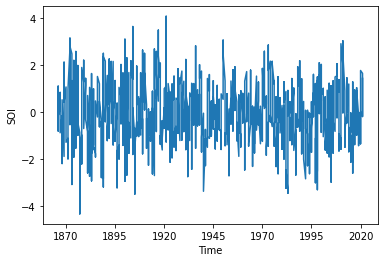

In [6]:
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))
#plt.gcf().autofmt_xdate()
plt.plot(year,soi)
plt.xticks(np.arange(1870, 2025, 25))
plt.xlabel("Time")
plt.ylabel("SOI")
#plt.savefig('SOI.pdf')

Text(0, 0.5, 'Pressure (hPa)')

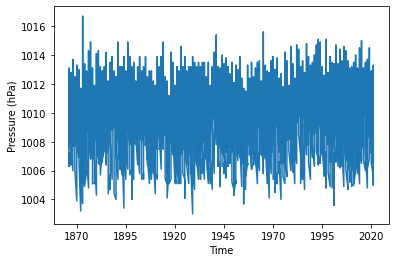

In [6]:
plt.plot(year,darwin)
plt.xticks(np.arange(1870, 2025, 25))
plt.xlabel("Time")
plt.ylabel("Pressure (hPa)")
#plt.savefig('Darwin.pdf')

Text(0, 0.5, 'Pressure (hPa)')

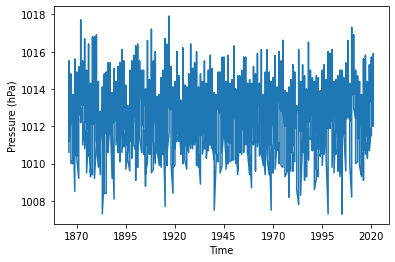

In [7]:
plt.plot(year,tahity)
plt.xticks(np.arange(1870, 2025, 25))
plt.xlabel("Time")
plt.ylabel("Pressure (hPa)")
#plt.savefig('Tahity.pdf')

Text(0, 0.5, 'BEI')

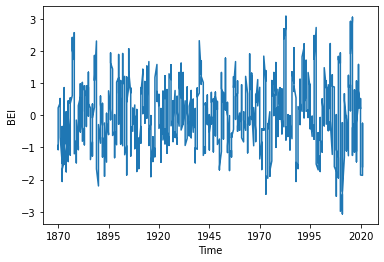

In [8]:
plt.plot(year_2,bei)
plt.xticks(np.arange(1870, 2025, 25))
plt.xlabel("Time")
plt.ylabel("BEI")
#plt.savefig('BEI.pdf')

## Análisis de la existencia de una ley de potencias

Utilizamos la biblioteca powerlaw para analizar las series de los modulos de las diferencias siguiendo los lineamientos del artículo "Power-Law Distributions in Empirical Data", Aaron Clauset et al. SIAM review Vol. 51, No. 4, pp. 66-703.

El uso de la biblioteca se detalla en "powerlaw: A Python Package for Analysis of Heavy-Tailed Distributions". Jeff Alstott et al. PLOS one January 2014 Vol. 9 Issue 1 e85777

### Ley de potencias en las fluctuaciones extremas

En primer lugar vamos a graficar un histograma con la función de la diferencia $x = y_{i+1}-y_i$. Luego generamos series con la diferencia $abs(y_{i+1}-y_i)$ y graficamos la curva de la Prob(X>x).


**"Statistical Analyses Support Power Law Distributions Found in Neuronal Avalanches"**

PLoS ONE May 2011 | Volume 6 | Issue 5 | e19779


In many cases, deciding whether a given empirical distribution
follows a power law and to determine its slope can be technically
challenging [11–15]. Until recently, whether a given distribution is
appropriately described by a power law was largely determined by
visual inspection of the distribution in a double-logarithmic plot
[2,16,17]. In such a presentation, a power law conveniently takes on
the form of a straight line. For neuronal avalanches, this feature and
the large deviation between the original distribution and shuffled,
exponentially distributed controls were interpreted as evidence in
favor of a power law [4,5]. As pointed out previously [13,14,18,19],
such a visual approach suffers from a lack of statistical rigor in
identifying a significant difference between a power law and an
exponential or other alternative model distributions. This problem
is worsened when the availability of the data is limited, for example,
for small sample sizes or when the range of values over which the
distribution is analyzed is narrow [13,15].
The reasons described above emphasize the need for more
stringent methods in testing the power law hypothesis for neuronal
avalanches. The present study was aimed to provide such an
analysis. More specifically, we performed the following three steps:
(i) finite-size scaling analysis to motivate the power law model as an
appropriate description for the distribution of avalanche sizes, (ii)
parameter estimation of the statistical models to determine the
slope of the power law and to allow the subsequent model
comparison, and (iii) comparison of the power law and the
exponentially truncated power law to the alternatives of an
exponential, a lognormal and a gamma distribution.
The model comparison was done by a likelihood ratio
test [14,18,20] and, additionally, by using a comparison that was
based on the Kolmogorov-Smirnov (KS) statistic. Both tests clearly
favored the power law models over the alternative distributions for
all data sets. Furthermore, good fits were also obtained by the
inverse Gaussian distribution, which describes a power law with
fixed exponent 21.5 and additional cut-off function. Taken
together, these results indicate that cluster size distributions in
neuronal avalanches scale according to a power law with
particular exponent a close to 21.5, which provides strong
support for critical state dynamics in superficial layers of cortex.

Comparar los resultados con:
1. **The global signature of the El Niño/La Niña Southern Oscillation.** INTERNATIONAL JOURNAL OF REMOTE SENSING, 2018
https://doi.org/10.1080/01431161.2018.1465617

2. **Power-law correlations in the southern-oscillation-index fluctuations characterizing El Niño** PRE 63,047201


In [7]:
d = np.diff(darwin)
t = np.diff(tahity)
s = np.diff(soi)
b = np.diff(bei)

In [8]:
hdy, hdx = np.histogram(d,100)
hty, htx = np.histogram(t,100)
hsy, hsx = np.histogram(s,100)
hby, hbx = np.histogram(b,100)

In [9]:
#comparacion con una distribucion normal
mu = np.mean(s)
sigma = np.std(s)
sn = np.random.normal(mu, sigma, len(s))
hyn, hxn = np.histogram(sn,100)

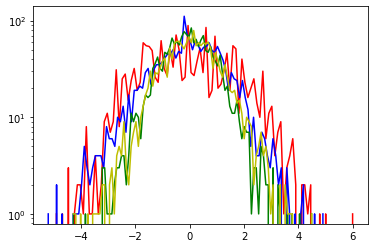

In [10]:
plt.yscale('log')
plt.plot(hdx[:-1],hdy,'r')
plt.plot(htx[:-1],hty,'b')
plt.plot(hsx[:-1],hsy,'g')
plt.plot(hsx[:-1],hby,'y')
#plt.plot(hxn[:-1],hyn,'y')

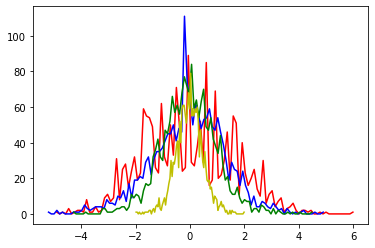

In [11]:
plt.plot(hdx[:-1],hdy,'r')
plt.plot(htx[:-1],hty,'b')
plt.plot(hsx[:-1],hsy,'g')
plt.plot(hbx[:-1],hby,'y')

A continuación vemos de reproducir los resultados del paper **The global signature of the El Niño/La Niña Southern Oscillation.** para el índice BEI.

(array([0.0075237 , 0.01956163, 0.07373229, 0.26934857, 0.63951476,
        0.82459786, 0.60039151, 0.21969213, 0.07222755, 0.01354267,
        0.00300948]),
 array([-1.98      , -1.61545455, -1.25090909, -0.88636364, -0.52181818,
        -0.15727273,  0.20727273,  0.57181818,  0.93636364,  1.30090909,
         1.66545455,  2.03      ]),
 <BarContainer object of 11 artists>)

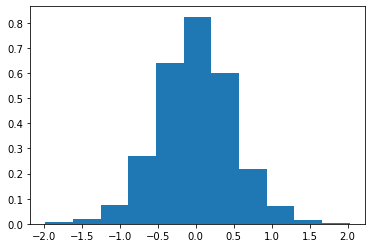

In [12]:
plt.hist(b, bins=11, density = True)

In [13]:
abs_b = np.abs(b)
xb, yb = pl.ccdf(abs_b)

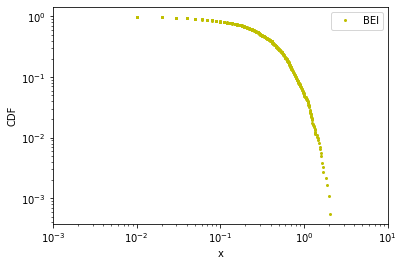

In [14]:
plt.loglog(xb,yb,'yo', markersize = 2, label = "BEI")
plt.xlabel("x")
plt.ylabel("CDF")
plt.xlim([0.001,10])
plt.legend()

In [15]:
fit_bei = pl.Fit(abs_b)
fit_bei.xmin

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


1.0999999999999999

In [16]:
print("BEI = ",fit_bei.power_law.alpha,fit_bei.power_law.sigma)

BEI =  6.997338385939035 0.6879418935401469


Ahora vamos a estudiar si existe una ley de potencias. Para ello primero graficamos la Cumulative distribution function (CDF).

In [17]:
fit_bei.supported_distributions

{'power_law': powerlaw.Power_Law,
 'lognormal': powerlaw.Lognormal,
 'exponential': powerlaw.Exponential,
 'truncated_power_law': powerlaw.Truncated_Power_Law,
 'stretched_exponential': powerlaw.Stretched_Exponential,
 'lognormal_positive': powerlaw.Lognormal_Positive}

In [18]:
fit_bei.distribution_compare('power_law', 'exponential')

(-0.45736750093341216, 0.605092236050184)

In [19]:
fit_bei.distribution_compare('exponential','power_law' )

(0.45736750093341216, 0.605092236050184)

In [20]:
fit_bei.distribution_compare('power_law', 'truncated_power_law')

Assuming nested distributions


(-0.4967989511074762, 0.31886460284495965)

In [21]:
fit_bei.distribution_compare('power_law', 'lognormal')

(-0.4062817155165118, 0.5241054992878572)

In [22]:
fit_bei.distribution_compare('power_law', 'lognormal_positive')

(0.7421532199312268, 0.6977253547994537)

<AxesSubplot:>

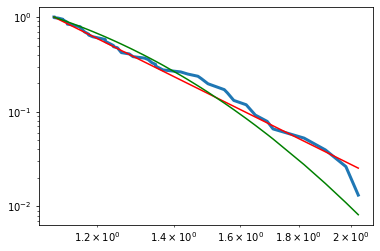

In [23]:
fig4 =fit_bei.plot_ccdf(linewidth = 3)
fit_bei.power_law.plot_ccdf(ax =fig4, color ='r')
fit_bei.lognormal_positive.plot_ccdf(ax = fig4, color = 'g')

In [24]:
abs_d = np.abs(d)
abs_t = np.abs(t)
abs_s = np.abs(s)

In [25]:
xd, yd = pl.ccdf(abs_d)
xt, yt = pl.ccdf(abs_t)
xs, ys = pl.ccdf(abs_s)
xb, yb = pl.ccdf(abs_b)

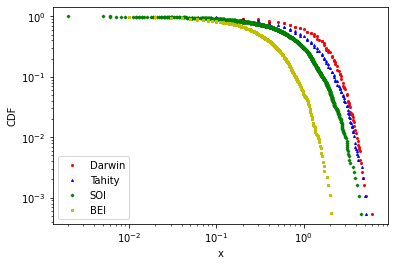

In [26]:
plt.loglog(xd,yd,'ro', markersize = 2, label = "Darwin")
plt.loglog(xt,yt,'b^', markersize = 2, label = "Tahity")
plt.loglog(xs,ys,'gD', markersize = 2, label = "SOI")
plt.loglog(xb,yb,'ys', markersize = 2, label = "BEI")
plt.xlabel("x")
plt.ylabel("CDF")
plt.legend()
plt.savefig("ccdf.pdf")

(1, 5)

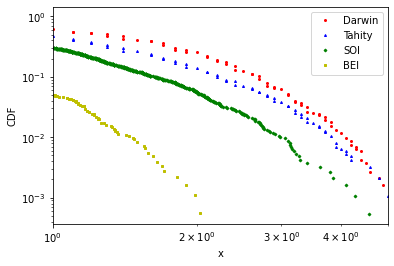

In [29]:
plt.loglog(xd,yd,'ro', markersize = 2, label = "Darwin")
plt.loglog(xt,yt,'b^', markersize = 2, label = "Tahity")
plt.loglog(xs,ys,'gD', markersize = 2, label = "SOI")
plt.loglog(xb,yb,'ys', markersize = 2, label = "BEI")
plt.xlabel("x")
plt.ylabel("CDF")
plt.legend()
plt.xlim([1, 5])

In [30]:
fit_darwin = pl.Fit(abs_d)
fit_tahity = pl.Fit(abs_t)
fit_soi = pl.Fit(abs_s)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [31]:
d_xmin = fit_darwin.xmin
t_xmin = fit_tahity.xmin
s_xmin = fit_soi.xmin
b_xmin = fit_bei.xmin

In [32]:
print("Estadistica elemental (mean and std)")
print("Darwin = ", np.mean(d), np.std(d))
print("Tahity = ", np.mean(t), np.std(t))
print("SOI = ", np.mean(s), np.std(s))
print("BEI = ", np.mean(b), np.std(b))

Estadistica elemental (mean and std)
Darwin =  -0.00037413148049173997 1.6521223151950832
Tahity =  0.001122394441475159 1.360673042772382
SOI =  0.0010919294494922507 1.0180146538644232
BEI =  -0.00036204059243006187 0.49806138772496433


In [33]:
print("x minimos")


x minimos


$$
\begin{aligned}
& \text {Power Law Fit}\\
&\begin{array}{crllrr}
\hline \hline \text { Index } & <x> & \sigma & x_{min} & \alpha  & \sigma_{\alpha}\\
\hline Darwin & -0.00037 & 1.652 &  4.400 & 11.549 & 3.73\\
Tahity & 0.00112 & 1.360 & 1.799 &  4.512 & 0.19\\
SOI & 0.00109 & 1.018 & 1.06 & 3.679 & 0.12\\
BEI & -0.00036 & 0.498 & 1.099 & 6.997 & 0.69\\
\hline
\end{array}
\end{aligned}
$$

In [34]:
print("Ajustes con ley de potencias")
print("Darwin = ",fit_darwin.power_law.alpha,fit_darwin.power_law.sigma)
print("Tahity = ",fit_tahity.power_law.alpha,fit_tahity.power_law.sigma)
print("SOI = ",fit_soi.power_law.alpha,fit_soi.power_law.sigma)
print("BEI = ",fit_bei.power_law.alpha,fit_bei.power_law.sigma)

Ajustes con ley de potencias
Darwin =  11.549083146660914 3.7296641141523272
Tahity =  4.512011902238325 0.18880692956464568
SOI =  3.679856818149641 0.11740665885191479
BEI =  6.997338385939035 0.6879418935401469


<AxesSubplot:>

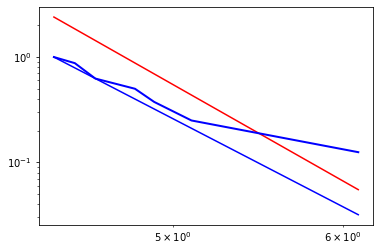

In [35]:
fig = fit_darwin.plot_pdf(color = 'r', linewidth = 2)
fit_darwin.power_law.plot_pdf(color = 'r', linestyle='-', ax = fig)
fit_darwin.plot_ccdf(color = 'b', linewidth = 2, ax = fig)
fit_darwin.power_law.plot_ccdf(color = 'b', linestyle = '-', ax = fig)

In [36]:
bin_edges, probability=fit_darwin.ccdf()
print(bin_edges, probability)

[4.4 4.5 4.6 4.8 4.9 5.1 6.1] [1.    0.875 0.625 0.5   0.375 0.25  0.125]


In [37]:
fit_darwin = pl.Fit(abs_d + 0.001)
fit_tahity = pl.Fit(abs_t + 0.001)
fit_soi = pl.Fit(abs_s + 0.001)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


In [38]:
print("Darwin = ",fit_darwin.power_law.alpha,fit_darwin.power_law.sigma)
print("Tahity = ",fit_tahity.power_law.alpha,fit_tahity.power_law.sigma)
print("SOI = ",fit_soi.power_law.alpha,fit_soi.power_law.sigma)


Darwin =  11.551262144409142 3.7304345061943085
Tahity =  4.513565990187281 0.1888904778503815
SOI =  3.6817715568373837 0.11749054507687273


In [39]:
print(fit_darwin.distribution_compare('power_law', 'exponential'))
print(fit_tahity.distribution_compare('power_law', 'exponential'))
print(fit_soi.distribution_compare('power_law', 'exponential'))
print(fit_bei.distribution_compare('power_law', 'exponential'))

(0.06823668810432701, 0.6954823858967393)
(-6.1410695541024385, 0.06766901673531504)
(-15.584750028660059, 0.002146493995298914)
(-0.45736750093341216, 0.605092236050184)


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


<AxesSubplot:>

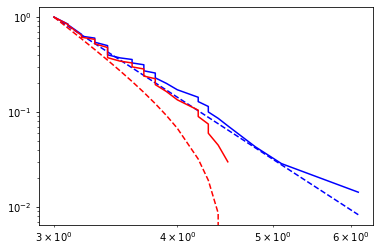

In [40]:
data = d
#FigCCDFmax = pl.plot_ccdf(data, linewidth=1)
fit = pl.Fit(data, xmax=None)
FigCCDFmax = fit.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
fit.power_law.plot_ccdf(color='b', linestyle='--', ax=FigCCDFmax, label=r"Fit, no $x_{max}$")
fit = pl.Fit(data, xmax=4.5)
fit.plot_ccdf(color='r', label=r"Empirical, $x_{max}=1000$")
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=FigCCDFmax, label=r"Fit, $x_{max}=1000$")

In [41]:
import urllib.request
data = urllib.request.urlretrieve('https://raw.github.com/jeffalstott/powerlaw/master/manuscript/words.txt', 'words.txt')

In [42]:
words = np.genfromtxt('words.txt')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


C:\Users\sebas\anaconda3\lib\site-packages\powerlaw.py:1195: RuntimeWarning: divide by zero encountered in double_scalars
  C = 1.0/C
C:\Users\sebas\anaconda3\lib\site-packages\scipy\optimize\optimize.py:761: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


C:\Users\sebas\anaconda3\lib\site-packages\powerlaw.py:840: RuntimeWarning: invalid value encountered in multiply
  likelihoods = f*C


<AxesSubplot:>

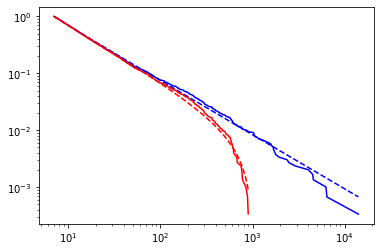

In [43]:
data = words
fit = pl.Fit(data, discrete=True, xmax=None)
FigCCDFmax = fit.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
fit.power_law.plot_ccdf(color='b', linestyle='--', ax=FigCCDFmax, label=r"Fit, no $x_{max}$")
fit = pl.Fit(data, discrete=True, xmax=1000)
fit.plot_ccdf(color='r', label=r"Empirical, $x_{max}=1000$")
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=FigCCDFmax, label=r"Fit, $x_{max}=1000$")

In [44]:
w, z = pl.ccdf(data)

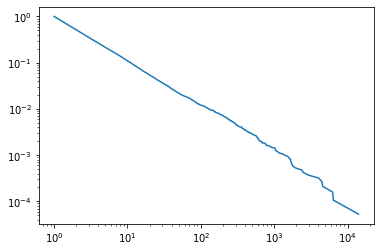

In [45]:
plt.loglog(w,z)

In [46]:
fit = pl.Fit(data, discrete=True)

Calculating best minimal value for power law fit


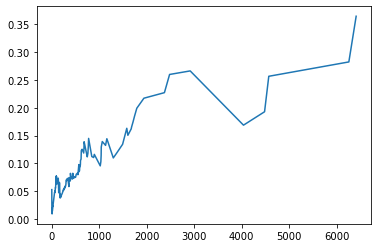

In [47]:
plt.plot(fit.xmins,fit.Ds)

In [48]:
fit.power_law.alpha

1.9501572269094178

In [49]:
fit.xmin

7.0

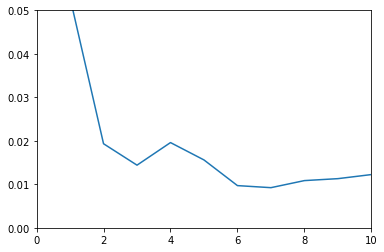

In [50]:
plt.xlim([0,10])
plt.ylim([0,.05])
plt.plot(fit.xmins,fit.Ds)

In [51]:
fit.distribution_compare('power_law', 'truncated_power_law')

Assuming nested distributions


(-0.917123083373983, 0.1756268316869548)

In [52]:
fit.distribution_compare('power_law','lognormal')

(0.008785246720703466, 0.9492243713201907)